In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn import metrics
import os

import data_util as util
from ts_net import TsNet

import logging
logging.basicConfig(level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(name)s: %(message)s")
logger = logging.getLogger(__name__)

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
class Args:
    def __init__(self, data_dir, target_obj, batch_size, win_size, corr_coef_pp, n_fold, rand_seed, max_epochs, log_n_iter, logdir):
        self.data_dir = data_dir
        self.target_obj = target_obj
        self.batch_size = batch_size
        self.win_size = win_size
        self.corr_coef_pp = corr_coef_pp
        self.n_fold = n_fold
        self.rand_seed = rand_seed
        self.max_epochs = max_epochs
        self.log_n_iter = log_n_iter
        self.logdir = logdir

In [3]:
# # configs

root_dir = "/home/yujin/ts_prediction_keras/data"
target_object = "Dog_1"
batch_size = 32
win_size = 8000
corr_coef_pp = 0.0
n_fold = 3
rand_seed = 11
max_epochs = 20
log_n_iter = 200
logdir = "./log"

args = Args(data_dir = root_dir,
            target_obj = target_object,
            batch_size = batch_size,
            win_size = win_size,
            corr_coef_pp = corr_coef_pp,
            n_fold = n_fold,
            rand_seed = rand_seed,
            max_epochs = max_epochs,
            log_n_iter = log_n_iter,
            logdir = logdir
           )

np.random.seed(args.rand_seed)

In [7]:
logdir, modeldir = util.create_log(args)

In [12]:
target_data_dir = os.path.join(args.data_dir, args.target_obj)
logger.info("target_data_dir={}".format(target_data_dir))
data, labels = util.load_train_data(target_data_dir)
train_sets, valid_sets = util.split_to_folds(data, labels, n_folds=args.n_fold)

2017-04-23 15:20:28,323 [INFO] __main__: target_data_dir=/home/yujin/ts_prediction_keras/data/Dog_1
2017-04-23 15:20:28,326 [INFO] data_util: #preictal_files = 24
2017-04-23 15:20:28,328 [INFO] data_util: #interictal_files = 480
2017-04-23 15:20:28,329 [INFO] data_util: Loading preictal data from /home/yujin/ts_prediction_keras/data/Dog_1 ...
2017-04-23 15:20:28,331 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_preictal_segment_0001.mat
2017-04-23 15:20:28,349 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_preictal_segment_0002.mat
2017-04-23 15:20:28,365 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_preictal_segment_0003.mat
2017-04-23 15:20:28,378 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_preictal_segment_0004.mat
2017-04-23 15:20:28,391 [INFO] data_util: filename=/home/yujin/ts_prediction_keras/data/Dog_1/Dog_1_preictal_segment_0005.mat
2017-04-23 15:20:28,403 [

In [13]:
fold_i = 0
train_data, train_labels = train_sets[fold_i]
valid_data, valid_labels = valid_sets[fold_i]
num_channel = train_data.shape[-1]
# calculate mean and std
tmp = train_data.reshape([-1, num_channel])
train_mean = np.mean(tmp, axis=0)
train_std = np.std(tmp, axis=0)
# build net
model = TsNet(args, train_mean, train_std, train_data, train_labels, valid_data, valid_labels)
model.build_model()
model.build_func()

2017-04-23 15:20:59,397 [INFO] ts_net: [<tf.Tensor 'corr_pp/Mean_2:0' shape=() dtype=float32>, <tf.Tensor 'corr_pp_1/Mean_2:0' shape=() dtype=float32>, <tf.Tensor 'corr_pp_2/Mean_2:0' shape=() dtype=float32>, <tf.Tensor 'prob/Sigmoid:0' shape=(?, 1) dtype=float32>]
2017-04-23 15:20:59,463 [INFO] ts_net: [0.0, 0.0, 0.0, 1.0]


In [ ]:
modelname = "bestmodel_fold" + str(fold_i) + ".h5"
train_hist = model.train(logdir, os.path.join(logdir, "model", modelname))

2017-04-23 15:21:45,862 [INFO] ts_net: max_epochs=20, steps_per_epoch=314, validation_steps=157
2017-04-23 15:21:46,868 [INFO] ts_net: num_pos_samples=16, num_neg_samples=320
2017-04-23 15:21:46,869 [INFO] ts_net: class_sampling_weights=[1.0, 10.0]
2017-04-23 15:21:46,869 [INFO] ts_net: data_fetcher off to work
2017-04-23 15:22:18,859 [INFO] ts_net: num_pos_samples=8, num_neg_samples=160
2017-04-23 15:22:18,860 [INFO] ts_net: class_sampling_weights=[1.0, 10.0]
2017-04-23 15:22:18,860 [INFO] ts_net: data_fetcher off to work


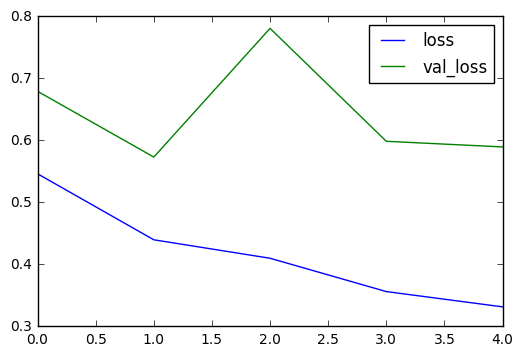

In [10]:
pd.DataFrame({"loss": train_hist.history["loss"],
              "val_loss": train_hist.history["val_loss"]}).plot()

In [9]:
layer_info = [(idx, layer.name, layer.output_shape) for idx, layer in enumerate(model.model.layers)]

logger.info("<Model architecture>")
for idx, name, shape in layer_info:
    logger.info("#{}: name={}, shape={}".format(idx, name, shape))

logger.info("<Model metrics>")
logger.info("metrics_names={}".format(model.model.metrics_names))

2017-04-23 12:32:15,724 [INFO] __main__: <Model architecture>
2017-04-23 12:32:15,725 [INFO] __main__: #0: name=data, shape=(None, 8000, 16)
2017-04-23 12:32:15,727 [INFO] __main__: #1: name=normalization, shape=(None, 8000, 16)
2017-04-23 12:32:15,728 [INFO] __main__: #2: name=conv1, shape=(None, 8000, 32)
2017-04-23 12:32:15,729 [INFO] __main__: #3: name=max_pooling1d_4, shape=(None, 2000, 32)
2017-04-23 12:32:15,730 [INFO] __main__: #4: name=pos_data1, shape=(None, 8000, 16)
2017-04-23 12:32:15,732 [INFO] __main__: #5: name=pos_data2, shape=(None, 8000, 16)
2017-04-23 12:32:15,733 [INFO] __main__: #6: name=conv2, shape=(None, 2000, 64)
2017-04-23 12:32:15,734 [INFO] __main__: #7: name=max_pooling1d_5, shape=(None, 1000, 64)
2017-04-23 12:32:15,735 [INFO] __main__: #8: name=conv3, shape=(None, 1000, 64)
2017-04-23 12:32:15,736 [INFO] __main__: #9: name=max_pooling1d_6, shape=(None, 500, 64)
2017-04-23 12:32:15,737 [INFO] __main__: #10: name=flatten, shape=(None, 32000)
2017-04-23 12:

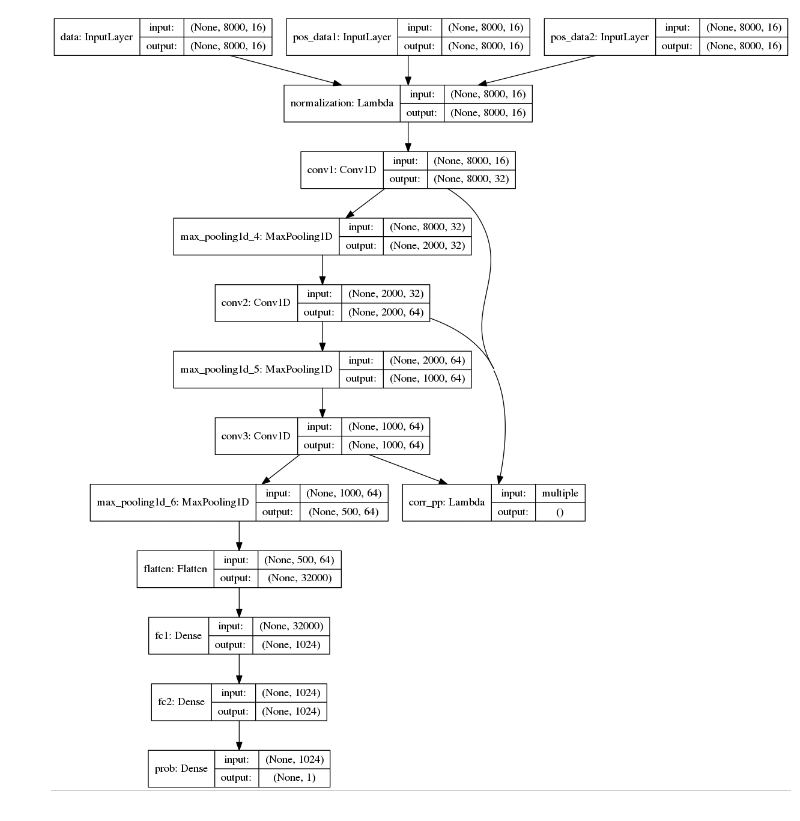

In [10]:
from keras.utils import plot_model
plot_model(model.model, to_file='model.png', show_shapes=True)
model_arch = plt.imread("model.png")
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(model_arch)
ax.set_axis_off()